In [1]:
%load_ext watermark

%watermark -v -m -p numpy,pandas,scipy,torch,matplotlib,imageio,PIL,cv2

CPython 3.6.5
IPython 6.4.0

numpy 1.14.3
pandas 0.23.0
scipy 1.1.0
torch 0.3.1.post2
matplotlib 2.2.2
imageio 2.3.0
PIL 5.1.0
cv2 3.3.1

compiler   : GCC 7.2.0
system     : Linux
release    : 3.16.0-4-amd64
machine    : x86_64
processor  : 
CPU cores  : 48
interpreter: 64bit


In [4]:
use_cuda = True

In [3]:
## First, check how many image files there are
import os

img_list = os.listdir('../images-dpmcrop-test/')
prot_list = os.listdir('../images-celebAtest-sameproto-aligned/')

print(len(img_list), len(prot_list))

19440 15023


# Dataset Loader

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import pandas as pd
import pyprind
import sys
from PIL import Image
import os
import pyprind


class CelebaDataset(Dataset):
    def __init__(self, image_path, proto_smG_path, proto_opG_path,
                 metadata_path, transform, mode): 
        self.image_path = image_path
        self.proto_smG_path = proto_smG_path
        self.proto_opG_path = proto_opG_path
        self.transform = transform
        self.proto_transform = transforms.ToTensor()
        self.mode = mode
        
        df = pd.read_csv(metadata_path, sep='\s+', skiprows=1)
        df.Male = df.Male.map({-1: 0, 1:1})
        self.df = df.reset_index()

        print ('Start preprocessing dataset..!')
        self.preprocess()
        print ('Finished preprocessing dataset..!')

        if self.mode == 'train':
            self.num_data = len(self.train_filenames)
        elif self.mode == 'test':
            self.num_data = len(self.test_filenames)

        print('******', self.num_data)
        
    def preprocess(self):
        image_files = set(os.listdir(self.image_path))
        protoSM_files = set(os.listdir(self.proto_smG_path))
        protoOP_files = set(os.listdir(self.proto_opG_path))
        
        existing_files = image_files & protoSM_files & protoOP_files
        print('existing_files : ', len(existing_files))
        self.train_filenames = []
        self.train_labels = []
        self.test_filenames = []
        self.test_labels = []

        pbar = pyprind.ProgBar(len(self.df))
        for row in self.df.iterrows():
            i = row[0]
            filename = row[1]['index']
            gender = row[1]['Male']

            if self.mode == 'train':
                if filename in existing_files:
                    self.train_filenames.append(filename)
                    self.train_labels.append(gender)
            elif self.mode == 'test':
                if filename in existing_files:
                    self.test_filenames.append(filename)
                    self.test_labels.append(gender)
            pbar.update()
        sys.stderr.flush()
        
    def __getitem__(self, index):
        if self.mode == 'train':
            fname = self.train_filenames[index]
        elif self.mode == 'test':
            fname = self.test_filenames[index]

        image = Image.open(os.path.join(self.image_path, fname))
        label = (self.test_labels[index],)
        smG_proto = Image.open(os.path.join(self.proto_smG_path, fname))
        opG_proto = Image.open(os.path.join(self.proto_opG_path, fname))

        return (self.transform(image), 
                self.proto_transform(smG_proto), self.proto_transform(opG_proto), 
                torch.LongTensor(label), fname)

    def __len__(self):
        return self.num_data
    
def get_loader(image_path, proto_same_path, proto_oppo_path, metadata_path,
               crop_size=(224,224), image_size=(224,224), batch_size=64,
               dataset='CelebA', mode='train',
               num_workers=1): 
    """Build and return data loader."""

    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
    ])

    dataset = CelebaDataset(image_path, proto_same_path, proto_oppo_path,
                            metadata_path, transform, mode) 

    if mode == 'train':
        shuffle = True
    else:
        shuffle = False

    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=num_workers)
    return data_loader

### Visualizing input images and their aligned prototypes

Start preprocessing dataset..!
existing_files :  15023


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:15


Finished preprocessing dataset..!
****** 15023
torch.Size([8, 1, 224, 224]) 
1.00000e-02 *
  5.4902  4.7059  4.7059
  2.7451  3.9216  5.0980
  2.3529  4.3137  5.8824
[torch.FloatTensor of size 3x3]

torch.Size([8, 3, 224, 224]) torch.Size([8, 3, 224, 224])


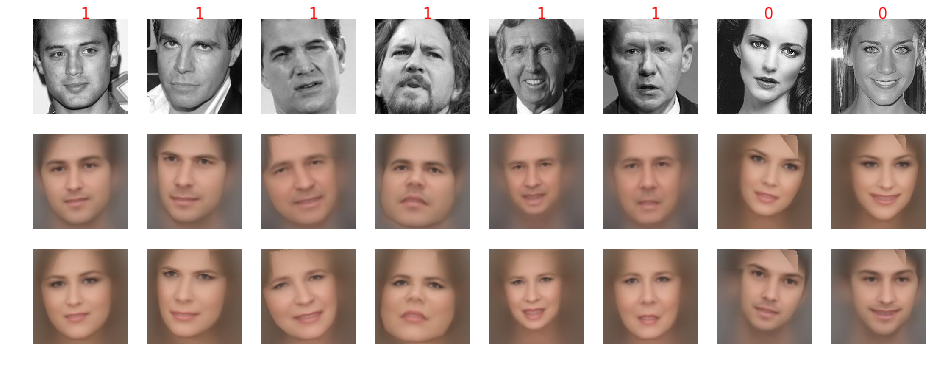

In [6]:
celeba_imgpath = '../images-dpmcrop-test/'
train_labelfile = '../list_attr_celeba.txt'
proto_samepath = '../images-celebAtest-sameproto-aligned/'
proto_oppopath = '../images-celebAtest-opGproto-aligned/'

data_loader = get_loader(image_path=celeba_imgpath,
                         proto_same_path = proto_samepath,
                         proto_oppo_path = proto_oppopath,
                         metadata_path = train_labelfile,
                         image_size=(224,224),
                         batch_size=8,
                         num_workers=1, mode='test')

img_tr = transforms.ToPILImage()

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

fig = plt.figure(figsize=(16, 6))
for batch_x,batch_smG,batch_opG,batch_y,batch_f in data_loader:
    print(batch_x.shape, batch_x[0, 0, :3, :3])
    print(batch_smG.shape, batch_opG.shape) 
    for i,(bx,bsm,bop,by) in enumerate(zip(batch_x, batch_smG, batch_opG, batch_y)):
        img = bx[0, :, :] 
        ax1 = fig.add_subplot(3, 8, i+1)
        ax1.imshow(img, cmap='gray')
        ax1.text(0.5, 1, by[0], 
                color='red', fontsize=15, 
                transform=ax1.transAxes)
        
        ax2 = fig.add_subplot(3, 8, i+9)
        ax2.imshow(img_tr(bsm), cmap='gray')

        ax3 = fig.add_subplot(3, 8, i+17)
        ax3.imshow(img_tr(bop), cmap='gray')

        for ax in [ax1, ax2, ax3]:
            ax.set_axis_off()
    break
plt.show()

## AutoEncoder

In [7]:
import pickle
import numpy as np

import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.autoencoder = nn.Sequential(
            ## Encoder
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(8, 12, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            ## Decoder
            nn.Conv2d(12, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest')
        )
        
        self.protocombiner = nn.Sequential(
            nn.Conv2d(131, 1, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, imgs, same_proto, oppo_proto):
        x = torch.cat([imgs, same_proto], dim=1)
        x = self.autoencoder(x)
        
        rec_same = torch.cat([x, same_proto], dim=1)
        rec_oppo = torch.cat([x, oppo_proto], dim=1)
                
        return self.protocombiner(rec_same), self.protocombiner(rec_oppo)


In [12]:
cae = AutoEncoder()

#use_cuda = False
if use_cuda:
    cae.cuda()

In [9]:
if use_cuda:
    x_var = Variable(batch_x).cuda()
    sm_var = Variable(batch_smG).cuda()
    op_var = Variable(batch_opG).cuda()
else:
    x_var = Variable(batch_x)
    sm_var = Variable(batch_smG)
    op_var = Variable(batch_opG)

cae(x_var, sm_var, op_var)[0].size()

torch.Size([8, 1, 224, 224])

In [10]:
import imageio

# Reconstruct the test samples

In [ ]:
celeba_imgpath = '../images-dpmcrop-test/'
train_labelfile = '../list_attr_celeba.txt'
proto_samepath = '../images-celebAtest-sameproto-aligned/'
proto_oppopath = '../images-celebAtest-opGproto-aligned/'

model_path = '../model/conv-autoencoder-e20.pkl'
save_path = '../output/'


if not os.path.exists(save_path):
    os.makedirs(save_path)


batch_size = 32


## autoencoder:
cae = AutoEncoder()

cae.load_state_dict(torch.load(model_path))
## freezing the gpred model
for param in cae.parameters():
    param.requires_grad = False
cae.eval()
if use_cuda:
    cae.cuda()

    
data_loader = get_loader(image_path=celeba_imgpath,
                         proto_same_path = proto_samepath,
                         proto_oppo_path = proto_oppopath,
                         metadata_path = train_labelfile,
                         image_size=(224,224),
                         batch_size=batch_size,
                         num_workers=1,
                         mode='test')

In [11]:


pbar = pyprind.ProgBar(len(data_loader))

for i,(batch_x,batch_smG,batch_opG,batch_y,batch_f) in enumerate(data_loader):
    if use_cuda:
        x_var = Variable(batch_x).cuda()
        sm_var = Variable(batch_smG).cuda()
        op_var = Variable(batch_opG).cuda()
    else:
        x_var = Variable(batch_x)
        sm_var = Variable(batch_smG)
        op_var = Variable(batch_opG)


    rec_sm, rec_op = cae(x_var, sm_var, op_var)
    
    for f,rec in zip(batch_f, rec_op.cpu().data.numpy()):
        imageio.imwrite(os.path.join(save_path, f), np.array(rec[0]*255, dtype='uint8'))

    pbar.update()


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:06:20


  15023   15023  165253
